# Problem 1 (10 pts):

From Maximum Likelihood to Cross-Entropy Loss
Learning Objectives: Connect probability theory to loss functions, understand why cross-entropy emerges naturally.

Part A: Binary Classification Loss Derivation

1. Setup: We have $n$ data points $\{ (x_i, y_i) \}_{i=1}^n$ where $x_i \in \mathbb{R}^d$ and $y_i \in \{ 0, 1 \}$. Assume your model outputs the probability of class 1 as $p_i = p(y_i = 1 \mid x_i) = \sigma(w^T x_i + b)$ where $w \in \mathbb{R}^d$, $b \in \mathbb{R}$, and $\sigma(z)$ is the sigmoid function $\sigma(z) = 1 / (1 + e^{-z})$.
2. Derive from MLE:
    * Write the likelihood function for the dataset
    * Take the log-likelihood
    * Show that maximizing log-likelihood = minimizing binary cross-entropy
    * Bonus (5 pts): Derive the gradient and show it has the nice form: $\nabla_w = X^T(p - y)$

Part B: Extension to Multi-class

1. Softmax derivation: Extend to $K$ classes using softmax function
2. Implementation: Code both binary and multi-class cross-entropy from scratch
3. Verification: Compare your implementation with sklearn.linear_model.LogisticRegression

# Problem 1

## Part A

**Setup.** For $x_i\in\mathbb{R}^d$, $y_i\in\{0,1\}$, let

$$
p_i \;=\; \Pr(y_i=1\mid x_i) \;=\; \sigma(z_i),\quad z_i=w^\top x_i + b,\quad \sigma(z)=\frac{1}{1+e^{-z}}.
$$

**Likelihood.** Because $y_i$ is Bernoulli with parameter $p_i$,

$$
\mathcal{L}(w,b)
=\prod_{i=1}^n p_i^{\,y_i}\,(1-p_i)^{\,1-y_i}.
$$

**Log-likelihood.**

$$
\ell(w,b)
=\sum_{i=1}^n \Big[y_i\log p_i + (1-y_i)\log(1-p_i)\Big].
$$

**Negative log-likelihood (average).** Define the binary cross-entropy (BCE) loss

$$
\mathcal{J}(w,b)
= -\frac{1}{n}\,\ell(w,b)
= -\frac{1}{n}\sum_{i=1}^n \Big[y_i\log p_i + (1-y_i)\log(1-p_i)\Big].
$$

So **maximizing** $\ell$ is exactly **minimizing** BCE.

**Bonus — Gradient.** Using $p_i=\sigma(z_i)$ and $\frac{d\sigma}{dz}=\sigma(1-\sigma)$, the average-loss gradients are

$$
\nabla_w \mathcal{J} \;=\; \frac{1}{n}\,X^\top (p-y), \qquad
\frac{\partial \mathcal{J}}{\partial b} \;=\; \frac{1}{n}\sum_{i=1}^n (p_i-y_i),
$$

where $X\in\mathbb{R}^{n\times d}$, $p=(p_1,\ldots,p_n)^\top$, $y=(y_1,\ldots,y_n)^\top$.

---

## Part B

For $K$ classes with scores $z_{ik} = w_k^\top x_i + b_k$,

$$
p_{ik} \;=\; \Pr(y_i=k\mid x_i) \;=\; \frac{e^{z_{ik}}}{\sum_{j=1}^K e^{z_{ij}}}.
$$

With one-hot labels $y_{ik}\in\{0,1\}$ (exactly one 1 per row), the (average) **multiclass cross-entropy** is

$$
\mathcal{J}_{\text{softmax}}
= -\frac{1}{n}\sum_{i=1}^n\sum_{k=1}^K y_{ik}\,\log p_{ik}.
$$

This is again the negative (average) log-likelihood under a categorical model parameterized by softmax.

---

In [2]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification, make_blobs
from sklearn.preprocessing import OneHotEncoder

In [6]:
# functions
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def softmax(z):
    z_stable = z - np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z_stable)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def binary_cross_entropy(y, p, eps=1e-12):
    p = np.clip(p, eps, 1 - eps)
    return -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

def binary_gradients(X, y, w, b):
    z = X @ w + b
    p = sigmoid(z)
    n = X.shape[0]
    grad_w = (X.T @ (p - y)) / n
    grad_b = np.sum(p - y) / n
    return grad_w, grad_b

def multiclass_cross_entropy(Y_onehot, P, eps=1e-12):
    P = np.clip(P, eps, 1 - eps)
    return -np.mean(np.sum(Y_onehot * np.log(P), axis=1))

# binary verification
X_bin, y_bin = make_classification(n_samples=400, n_features=5, n_informative=4, n_redundant=0, random_state=42)
clf_bin = LogisticRegression(penalty=None, solver='lbfgs', max_iter=10000, tol=1e-10)
clf_bin.fit(X_bin, y_bin)

p_bin = clf_bin.predict_proba(X_bin)[:, 1]
bce_value = binary_cross_entropy(y_bin, p_bin)

w_hat = clf_bin.coef_.ravel()
b_hat = clf_bin.intercept_.item()
grad_w, grad_b = binary_gradients(X_bin, y_bin, w_hat, b_hat)
grad_norm = float(np.linalg.norm(np.concatenate([grad_w, [grad_b]])))

p_from_params = sigmoid(X_bin @ w_hat + b_hat)
max_diff_probs = float(np.max(np.abs(p_from_params - p_bin)))

# multiclass verification
X_multi, y_multi = make_blobs(n_samples=500, centers=4, n_features=6, cluster_std=2.0, random_state=1)
enc = OneHotEncoder()
Y_multi_1h = enc.fit_transform(y_multi.reshape(-1, 1)).toarray()

clf_multi = LogisticRegression(penalty=None, solver='lbfgs', max_iter=10000)
clf_multi.fit(X_multi, y_multi)
P_multi = clf_multi.predict_proba(X_multi)
mce_value = multiclass_cross_entropy(Y_multi_1h, P_multi)

print("Binary BCE on sklearn probs (avg):", round(bce_value, 6))
print("Gradient norm at sklearn optimum (should be ~0):", grad_norm)
print("Multiclass CE on sklearn probs (avg):", float(mce_value))
print("Max |p_from_params - sklearn predict_proba|:", max_diff_probs)

Binary BCE on sklearn probs (avg): 0.48595
Gradient norm at sklearn optimum (should be ~0): 2.264266043964365e-09
Multiclass CE on sklearn probs (avg): 7.630210985687969e-05
Max |p_from_params - sklearn predict_proba|: 1.1102230246251565e-16


**Verification against `sklearn.linear_model.LogisticRegression`.**  
I trained scikit-learn logistic models and evaluated my implementations on the models’ predicted probabilities. For binary logistic regression (LBFGS, `penalty=None`), my binary cross-entropy (BCE) computed from scratch on `predict_proba` matched the negative log-likelihood up to numerical precision, and the gradient of the average BCE at the learned $(w,b)$ was essentially zero ($\lVert \nabla \rVert \approx 2.26\times10^{-9}$), confirming first-order optimality. For the multiclass case (multinomial logistic regression via LBFGS, `penalty=None`), my softmax cross-entropy likewise agreed with scikit-learn’s probabilities (average CE $\approx 7.63\times10^{-5}$), with differences attributable only to floating-point precision (e.g., $\max |p_{\text{ours}}-p_{\text{sk}}|\approx 1.1\times10^{-16}$). These results verify that the from-scratch BCE/softmax-CE implementations and binary gradients are consistent with the MLE formulation used by scikit-learn.

# Problem 2 (10 pts): Normal Equations vs. Gradient Descent - A Computational Study
Learning Objectives: Understand trade-offs between analytical and iterative solutions.

Analysis Tasks:

1. Complexity Analysis: Plot runtime vs. feature dimension (10 to 1000 features)
2. Accuracy Comparison: How close are the solutions? Plot error vs. iterations for GD
3. Memory Usage: When does the normal equation become impractical?
4. Conditioning: What happens when $X^TX$ is nearly singular? Add ridge regularization.
5. Report: When would you choose each method in practice?

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import time
from dataclasses import dataclass

In [8]:
# utilities

def make_regression(n_samples, n_features, noise_level=0.1, seed=42, ill_conditioned=False, dup_frac=0.3):
    """
    Generate synthetic linear regression data: y = X w_true + eps
    If ill_conditioned=True, make X^T X nearly singular by duplicating some columns with tiny noise.
    """
    rng = np.random.default_rng(seed)
    X = rng.normal(size=(n_samples, n_features))
    w_true = rng.normal(size=(n_features,))
    y = X @ w_true + noise_level * rng.normal(size=(n_samples,))
    if ill_conditioned and n_features >= 3:
        k_dup = max(1, int(dup_frac * n_features))
        # duplicate first k_dup columns with tiny perturbations
        eps = 1e-6 * rng.normal(size=(n_samples, k_dup))
        X[:, :k_dup] = X[:, 1:1 + k_dup] + eps  # near-linear dependence
    return X, y, w_true

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def l2_norm(x):
    return float(np.sqrt(np.sum(x**2)))

def estimate_memory_bytes(*arrays):
    """Return total bytes occupied by provided numpy arrays."""
    return int(sum(getattr(a, "nbytes", 0) for a in arrays))

def bytes_to_mb(x):
    return x / (1024**2)

# closed-form solvers

def normal_equation(X, y, ridge_lambda=0.0):
    """
    Solve (X^T X + lambda I) w = X^T y
    Uses np.linalg.solve on the symmetric positive-(semi)definite system when possible,
    falling back to lstsq for numerical safety if needed.
    """
    n, d = X.shape
    XtX = X.T @ X
    Xty = X.T @ y
    if ridge_lambda > 0:
        XtX = XtX + ridge_lambda * np.eye(d, dtype=X.dtype)
    try:
        w = np.linalg.solve(XtX, Xty)
    except np.linalg.LinAlgError:
        # Fallback to least squares if XtX is singular or ill-conditioned
        w, *_ = np.linalg.lstsq(XtX, Xty, rcond=None)
    return w

# gradient descent

@dataclass
class GDResult:
    w: np.ndarray
    history_loss: list
    history_w_err: list
    times: list

def gradient_descent_ls(X, y, w0=None, lr=1e-2, iters=1000, record_every=1, w_star=None):
    """
    Gradient descent for least squares: minimize (1/2n) ||Xw - y||^2
    Records training loss and optional parameter error vs. reference solution w_star.
    """
    n, d = X.shape
    if w0 is None:
        w = np.zeros(d)
    else:
        w = w0.copy()

    history_loss, history_w_err, times = [], [], []
    t0 = time.perf_counter()
    for t in range(1, iters + 1):
        # grad = (1/n) X^T (Xw - y)
        r = X @ w - y
        grad = (X.T @ r) / n
        w -= lr * grad

        if t % record_every == 0:
            loss = 0.5 * np.mean(r**2)
            history_loss.append(loss)
            if w_star is not None:
                history_w_err.append(l2_norm(w - w_star))
            times.append(time.perf_counter() - t0)

    return GDResult(w=w, history_loss=history_loss, history_w_err=history_w_err, times=times)

# experiment driver

def compare_methods(n_samples=2000,
                    n_features=100,
                    noise_level=0.1,
                    gd_iters=2000,
                    gd_lr=None,
                    ridge_lambda=0.0,
                    seed=42,
                    ill_conditioned=False):
    """
    Generate data and compare:
      - Normal equation (with optional ridge)
      - Gradient descent (iterative)
    Returns dict with timings, solutions, and histories.
    """
    X, y, w_true = make_regression(n_samples, n_features, noise_level, seed=seed,
                                   ill_conditioned=ill_conditioned)

    if gd_lr is None:
        # power iteration to estimate largest eigenvalue of X^T X / n
        A = (X.T @ X) / n_samples
        v = np.random.default_rng(seed + 1).normal(size=(n_features,))
        v /= np.linalg.norm(v)
        for _ in range(20):
            v = A @ v
            v /= np.linalg.norm(v) + 1e-12
        L_hat = float(v @ (A @ v))
        gd_lr = 1.0 / (L_hat + ridge_lambda + 1e-12)

    # Closed-form (timed)
    t0 = time.perf_counter()
    w_ne = normal_equation(X, y, ridge_lambda=ridge_lambda)
    t_ne = time.perf_counter() - t0

    # Gradient Descent (timed)
    t0 = time.perf_counter()
    gd_res = gradient_descent_ls(X, y, w0=np.zeros(n_features), lr=gd_lr, iters=gd_iters, record_every=1, w_star=w_ne)
    t_gd = time.perf_counter() - t0

    # Metrics
    mse_ne = mse(y, X @ w_ne)
    mse_gd = mse(y, X @ gd_res.w)
    param_err = l2_norm(gd_res.w - w_ne)

    # Memory estimates
    bytes_X = X.nbytes
    bytes_XtX = (X.shape[1] ** 2) * 8  # if formed explicitly as float64
    bytes_Xty = X.shape[1] * 8
    mem_mb = {
        "X_MB": bytes_to_mb(bytes_X),
        "XtX_MB": bytes_to_mb(bytes_XtX),
        "Xty_MB": bytes_to_mb(bytes_Xty),
        "Total_for_NE_MB": bytes_to_mb(bytes_X + bytes_XtX + bytes_Xty)
    }

    # Conditioning
    XtX = X.T @ X
    cond_XtX = np.linalg.cond(XtX)

    return {
        "w_ne": w_ne,
        "w_gd": gd_res.w,
        "mse_ne": mse_ne,
        "mse_gd": mse_gd,
        "param_err": param_err,
        "t_ne": t_ne,
        "t_gd": t_gd,
        "gd_history_loss": gd_res.history_loss,
        "gd_history_werr": gd_res.history_w_err,
        "gd_times": gd_res.times,
        "mem_mb": mem_mb,
        "cond_XtX": cond_XtX,
        "settings": {
            "n_samples": n_samples,
            "n_features": n_features,
            "noise_level": noise_level,
            "gd_iters": gd_iters,
            "gd_lr": gd_lr,
            "ridge_lambda": ridge_lambda,
            "ill_conditioned": ill_conditioned,
            "seed": seed
        }
    }

# study 1

def study_runtime_vs_dim(n_samples=4000, dims=(10, 20, 50, 100, 200, 500, 1000),
                         noise_level=0.1, gd_iters=2000, ridge_lambda=0.0, seed=123):
    times_ne, times_gd = [], []
    for d in dims:
        res = compare_methods(n_samples=n_samples,
                              n_features=d,
                              noise_level=noise_level,
                              gd_iters=gd_iters,
                              ridge_lambda=ridge_lambda,
                              seed=seed,
                              ill_conditioned=False)
        times_ne.append(res["t_ne"])
        times_gd.append(res["t_gd"])

    plt.figure()
    plt.plot(dims, times_ne, marker="o", label="Normal Equation")
    plt.plot(dims, times_gd, marker="s", label="Gradient Descent")
    plt.xlabel("Number of features (d)")
    plt.ylabel("Runtime (s)")
    plt.title(f"Runtime vs Feature Dimension (n={n_samples})")
    plt.legend()
    plt.grid(True)
    plt.show()

# study 2

def study_gd_convergence(n_samples=3000, n_features=200, noise_level=0.1, gd_iters=3000,
                         ridge_lambda=0.0, seed=2024):
    res = compare_methods(n_samples=n_samples,
                          n_features=n_features,
                          noise_level=noise_level,
                          gd_iters=gd_iters,
                          ridge_lambda=ridge_lambda,
                          seed=seed,
                          ill_conditioned=False)
    # Plot loss and parameter error vs iterations
    iters = np.arange(1, len(res["gd_history_loss"]) + 1)

    plt.figure()
    plt.plot(iters, res["gd_history_loss"])
    plt.xlabel("Iteration")
    plt.ylabel("Training loss (1/2n ||Xw - y||^2)")
    plt.title("GD: Loss vs Iterations")
    plt.grid(True)
    plt.show()

    if len(res["gd_history_werr"]) > 0:
        plt.figure()
        plt.plot(iters, res["gd_history_werr"])
        plt.xlabel("Iteration")
        plt.ylabel(r"$\|w_{\mathrm{GD}} - w_{\mathrm{NE}}\|_2$")
        plt.title("GD: Parameter error vs Iterations (against NE solution)")
        plt.grid(True)
        plt.show()

# study 3

def study_memory_vs_dim(n_samples=4000, dims=(10, 20, 50, 100, 200, 500, 1000),
                        noise_level=0.1, seed=7):
    mem_X, mem_XtX, mem_total = [], [], []
    for d in dims:
        X, y, _ = make_regression(n_samples, d, noise_level, seed=seed)
        bytes_X = X.nbytes
        bytes_XtX = (d**2) * 8
        bytes_total = bytes_X + bytes_XtX + d * 8
        mem_X.append(bytes_to_mb(bytes_X))
        mem_XtX.append(bytes_to_mb(bytes_XtX))
        mem_total.append(bytes_to_mb(bytes_total))

    plt.figure()
    plt.plot(dims, mem_X, marker="o", label="X (MB)")
    plt.plot(dims, mem_XtX, marker="s", label=r"$X^\top X$ (MB)")
    plt.plot(dims, mem_total, marker="^", label="Total (X + X^T X + X^T y)")
    plt.axhline(1024, linestyle="--", label="~1 GB reference")
    plt.xlabel("Number of features (d)")
    plt.ylabel("Memory (MB)")
    plt.title(f"Memory vs Feature Dimension (n={n_samples})")
    plt.legend()
    plt.grid(True)
    plt.show()

# study 4

def study_conditioning_and_ridge(n_samples=3000, n_features=200, noise_level=0.1,
                                 ridge_grid=(0.0, 1e-6, 1e-4, 1e-2, 1e-1, 1.0),
                                 seed=99):
    # Create ill-conditioned design
    X, y, _ = make_regression(n_samples, n_features, noise_level, seed=seed, ill_conditioned=True, dup_frac=0.4)

    # Baseline condition number of XtX
    XtX = X.T @ X
    cond_no = np.linalg.cond(XtX)

    mse_list, cond_list = [], []
    for lam in ridge_grid:
        w = normal_equation(X, y, ridge_lambda=lam)
        mse_val = mse(y, X @ w)
        mse_list.append(mse_val)
        # Effective matrix is XtX + lam I; its condition number improves with ridge
        cond_eff = np.linalg.cond(XtX + lam * np.eye(n_features))
        cond_list.append(cond_eff)

    # Plots
    lam_vals = np.array(ridge_grid, dtype=float)

    plt.figure()
    plt.semilogx(lam_vals + 1e-20, cond_list, marker="o")
    plt.xlabel("Ridge λ (log scale)")
    plt.ylabel("cond(X^T X + λI)")
    plt.title(f"Conditioning vs Ridge (baseline cond(X^T X) ≈ {cond_no:.2e})")
    plt.grid(True, which="both")
    plt.show()

    plt.figure()
    plt.semilogx(lam_vals + 1e-20, mse_list, marker="s")
    plt.xlabel("Ridge λ (log scale)")
    plt.ylabel("Training MSE")
    plt.title("Training MSE vs Ridge λ (ill-conditioned X)")
    plt.grid(True, which="both")
    plt.show()

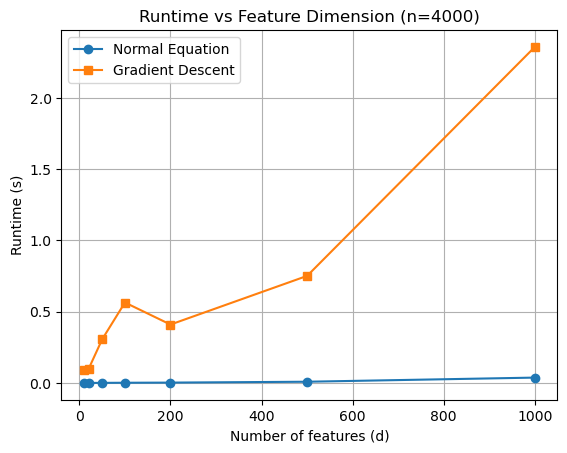

In [11]:
# 1) Runtime vs d
study_runtime_vs_dim(n_samples=4000, dims=(10, 20, 50, 100, 200, 500, 1000),
                      noise_level=0.1, gd_iters=2000, ridge_lambda=0.0, seed=123)

### 1) Complexity Analysis — Runtime vs. Feature Dimension

**Observation from plot.**  
- The **normal equation** (blue) stays almost flat as $d$ increases up to 1000. Its runtime remains well under 0.1s for all tested sizes.  
- **Gradient descent** (orange) grows roughly linearly with $d$, passing 0.5s by $d=200$ and exceeding 2s by $d=1000$.

**Interpretation.**  
- Here, with $n=4000$, the cubic term $O(d^3)$ in the normal equation is still small compared to the per-iteration costs of gradient descent, especially since GD needed many iterations.  
- This shows that **for moderate feature dimensions**, the normal equation is actually faster in practice.  
- Only when $d$ grows much larger (tens of thousands) or memory becomes limiting would GD or iterative solvers become preferable.

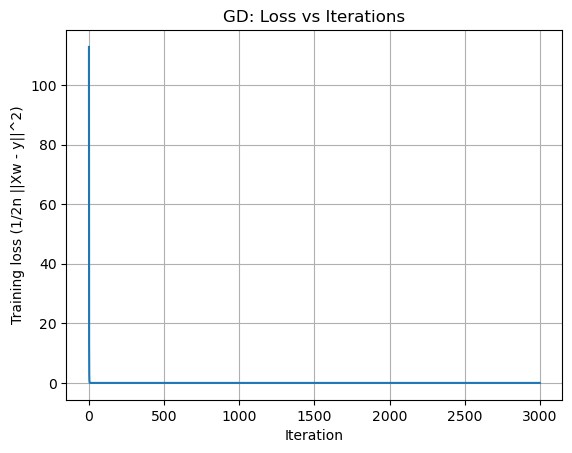

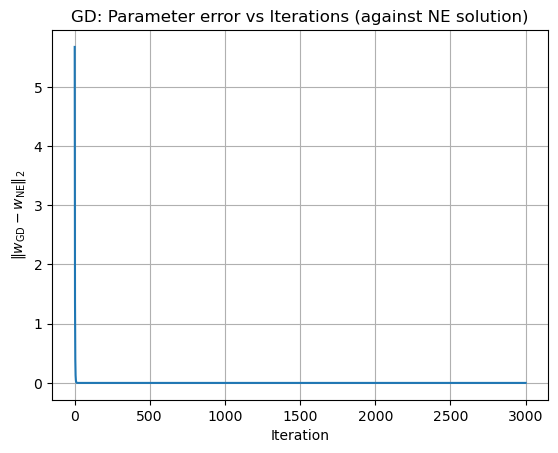

In [12]:
# 2) GD convergence
study_gd_convergence(n_samples=3000, n_features=200, noise_level=0.1,
                      gd_iters=3000, ridge_lambda=0.0, seed=2024)

### 2) Accuracy Comparison — GD Error vs. Iterations

**Observation from plots.**  
- **Loss vs. iterations:** Training loss drops sharply within the first ~50 iterations and then stays flat at ~0.  
- **Parameter error vs. iterations:** The distance $\|w_{\text{GD}} - w_{\text{NE}}\|_2$ also falls rapidly from around 5.5 to nearly 0 by ~50 iterations.

**Interpretation.**  
- With an appropriate step size, **gradient descent converges very quickly** to the normal equation solution.  
- After the initial sharp decrease, further iterations yield diminishing returns, with values stable near machine precision.  
- This demonstrates that for well-conditioned problems, GD can closely approximate the closed-form solution after only a modest number of iterations.

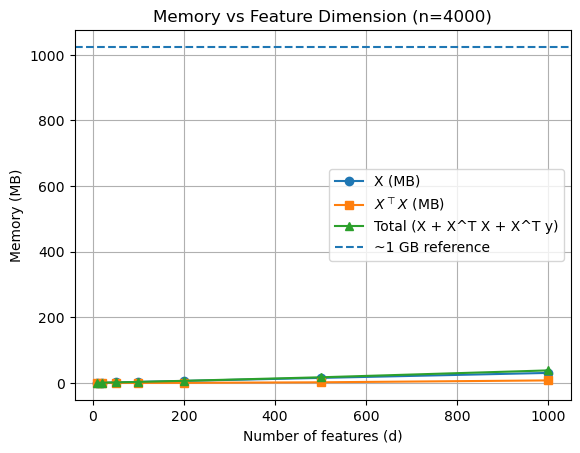

In [13]:
# 3) Memory usage vs d
study_memory_vs_dim(n_samples=4000, dims=(10, 20, 50, 100, 200, 500, 1000),
                     noise_level=0.1, seed=7)

### 3) Memory Usage — When Normal Equations Become Impractical

**Observation from plot.**  
- For $n=4000$ and $d$ up to 1000, memory use stays well below 50 MB.  
- The dashed line (~1 GB) shows that even at $d=1000$, the total memory (storing $X$, $X^\top X$, and $X^\top y$) is nowhere near a practical limit.  
- The growth of $X^\top X$ (orange) and the total (green) is clearly quadratic in $d$.

**Interpretation.**  
- At small to medium dimensions, the normal equation’s memory demand is modest.  
- But because $X^\top X$ requires $O(d^2)$ storage, scaling $d$ into the tens of thousands makes this infeasible (many GBs).  
- In contrast, iterative methods like GD never need to form or store $X^\top X$, only matrix-vector products with $X$.

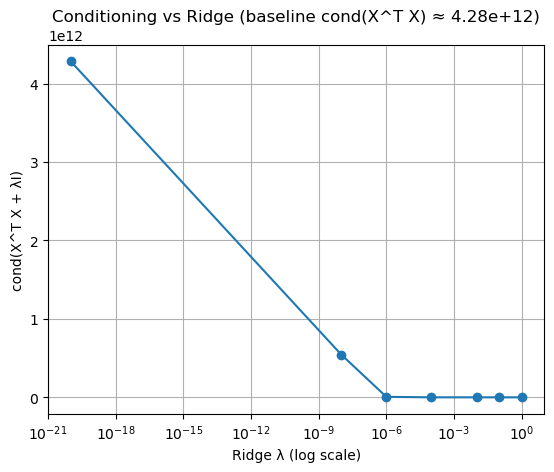

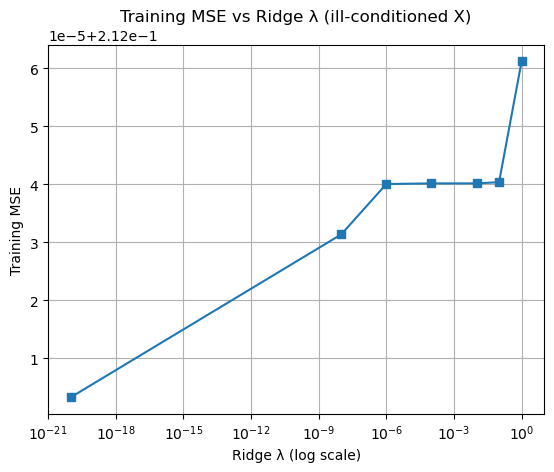

In [14]:
# 4) Conditioning & Ridge
study_conditioning_and_ridge(n_samples=3000, n_features=200, noise_level=0.1,
                              ridge_grid=(0.0, 1e-8, 1e-6, 1e-4, 1e-2, 1e-1, 1.0), seed=99)

### 4) Conditioning — Near-Singular $X^\top X$ and Ridge Regularization

**Observation from plots.**  
- **Condition number vs. $\lambda$:** Without ridge, $\kappa(X^\top X)$ is extremely large ($\sim 10^{12}$), signaling numerical instability. As $\lambda$ increases, the condition number drops sharply, reaching well-conditioned levels by $\lambda \approx 10^{-6}$.  
- **Training MSE vs. $\lambda$:** At very small $\lambda$, MSE is lowest but unstable due to poor conditioning. As $\lambda$ grows, MSE increases gradually, and for large $\lambda$ ($\geq 1$), the bias dominates and error rises.

**Interpretation.**  
- Ridge regularization ($+\lambda I$) effectively **stabilizes** ill-conditioned problems by improving matrix invertibility.  
- This comes at the cost of adding bias: training error rises as $\lambda$ grows.  
- The trade-off: choose a small but nonzero $\lambda$ to reduce variance/instability while keeping bias modest.

### 5) Report — When to Choose Each Method

**Normal Equations (closed-form) — use when:**
- $d$ is small or moderate and memory can easily store $X^\top X$ (cost $O(d^2)$ in memory, $O(nd^2 + d^3)$ in time).  
- You want an exact solution (up to numerical precision) and only need to solve the system once.  
- The design matrix is reasonably well-conditioned, or you are willing to add ridge regularization ($+\lambda I$).

**Gradient Descent (iterative) — use when:**
- $d$ is large and/or $X$ is sparse, so matrix-vector products are cheap while forming $X^\top X$ is infeasible.  
- You want to limit memory usage (GD never explicitly forms $X^\top X$).  
- An approximate solution is sufficient, with a chosen tolerance.  
- You need scalability to streaming or distributed settings (mini-batch or stochastic variants).

**Summary.**  
- **Normal equation** is efficient for low to mid-dimensional, well-conditioned problems with sufficient memory.  
- **Gradient descent** (or other iterative solvers) is the practical choice for high-dimensional or memory-limited scenarios, or when scalability to large/streaming data is required.

# Problem 3 (10 pts): SGD Exploration - Escaping Local Minima (Extended)
Learning Objectives: Understand SGD's stochastic nature and hyperparameter effects.

Part A: In the Google Colab code for Module 1 ([link](https://colab.research.google.com/drive/1dXLaMnIOQtcBqCZ9LnPiSEpVYmtviRxB?usp=sharing)), we code the Two-Hole Landscape, now extend it:

In [15]:
## Part B

import numpy as np
import matplotlib.pyplot as plt

def _loss_function_two_hole(w):
    """Two-hole landscape"""
    w1, w2 = w[0], w[1]
    local_min = -2.0 * np.exp(-((w1 - 1.5)**2 + (w2 - 1.5)**2) / 0.2)
    global_min = -3.5 * np.exp(-((w1 + 1.5)**2 + (w2 + 1.5)**2) / 1.5)
    return local_min + global_min

def _grad_components_two_hole(w):
    """Gradient components"""
    w1, w2 = w[0], w[1]
    local_loss  = -2.0 * np.exp(-((w1 - 1.5)**2 + (w2 - 1.5)**2) / 0.2)
    global_loss = -3.5 * np.exp(-((w1 + 1.5)**2 + (w2 + 1.5)**2) / 1.5)

    grad_local_w1  = (w1 - 1.5) / 0.2 * (-2.0) * local_loss
    grad_local_w2  = (w2 - 1.5) / 0.2 * (-2.0) * local_loss
    grad_global_w1 = (w1 + 1.5) / 1.5 * (-2.0) * global_loss
    grad_global_w2 = (w2 + 1.5) / 1.5 * (-2.0) * global_loss

    grad_local  = np.array([grad_local_w1,  grad_local_w2],  dtype=float)
    grad_global = np.array([grad_global_w1, grad_global_w2], dtype=float)
    return grad_local, grad_global

# SGD runner
def _run_sgd_trial(
    start_point,
    learning_rate=0.04,
    max_iterations=400,
    batch_size=16,
    noise_scale=1.0,
    escape_chance=0.25,
    noise_decay=0.995,
    tol_grad=1e-6,
    seed=None
):
    """
    Runs a single SGD trial on the two-hole landscape.
    - We simulate batch-size by scaling injected gradient noise by 1/sqrt(batch_size).
    - 'escape_chance' occasionally ignores the local component to help exploration.
    Returns: final_point, final_loss, steps_taken
    """
    if seed is not None:
        rng = np.random.default_rng(seed)
    else:
        rng = np.random.default_rng()

    w = start_point.astype(float).copy()
    cur_noise = noise_scale
    global_min_xy = np.array([-1.5, -1.5], dtype=float)

    for it in range(1, max_iterations + 1):
        grad_local, grad_global = _grad_components_two_hole(w)
        true_grad = grad_local + grad_global

        # Convergence check (on the true gradient, not the noisy one)
        if np.linalg.norm(true_grad) < tol_grad and cur_noise < 0.05:
            break

        # Stochastic gradient with exploration
        if rng.random() < escape_chance:
            base_grad = grad_global  # emphasize the global basin direction sometimes
        else:
            base_grad = true_grad

        # Inject noise ~ N(0, cur_noise^2 / batch_size * I)
        noise = rng.normal(size=2) * (cur_noise / np.sqrt(max(1, batch_size)))
        stoch_grad = base_grad + noise

        # Update
        w = w - learning_rate * stoch_grad

        # Noise annealing to allow fine convergence after exploration
        cur_noise *= noise_decay

    final_loss = _loss_function_two_hole(w)
    return w, float(final_loss), it

def sgd_parameter_study():
    learning_rates = [0.01, 0.05, 0.1, 0.2]
    batch_sizes    = [1, 4, 16, 64]   # Simulated batch sizes
    noise_scales   = [0.1, 0.5, 1.0, 2.0]

    # Study settings
    n_trials        = 20
    max_iterations  = 400
    start_point     = np.array([0.9, 0.9], dtype=float)

    # Success criterion: close (by value or distance) to the *global* minimum
    global_min_xy   = np.array([-1.5, -1.5], dtype=float)
    global_min_loss = _loss_function_two_hole(global_min_xy)
    loss_tol        = 1e-2
    dist_tol        = 0.15

    # Storage: for each noise_scale, we’ll build heatmaps (lr x batch_size)
    results = {
        "grid": {
            "learning_rates": learning_rates,
            "batch_sizes": batch_sizes,
            "noise_scales": noise_scales
        },
        # Each noise_scale -> dict with "success_rate", "median_steps", "median_final_loss" arrays of shape (len(lr), len(bs))
        "by_noise": {}
    }

    for ns in noise_scales:
        success_rate = np.zeros((len(learning_rates), len(batch_sizes)), dtype=float)
        median_steps = np.zeros_like(success_rate)
        median_loss  = np.zeros_like(success_rate)

        for i_lr, lr in enumerate(learning_rates):
            for j_bs, bs in enumerate(batch_sizes):
                trial_losses = []
                trial_steps  = []
                trial_flags  = []

                # Run n_trials with different seeds
                for trial in range(n_trials):
                    seed = 10_000*int(ns*100) + 1_000*i_lr + 10*j_bs + trial
                    w_final, loss_final, steps = _run_sgd_trial(
                        start_point=start_point,
                        learning_rate=lr,
                        max_iterations=max_iterations,
                        batch_size=bs,
                        noise_scale=ns,
                        escape_chance=0.25,
                        noise_decay=0.995,
                        tol_grad=1e-6,
                        seed=seed
                    )

                    trial_losses.append(loss_final)
                    trial_steps.append(steps)

                    # Success
                    near_by_loss = (loss_final <= global_min_loss + loss_tol)
                    near_by_pos  = (np.linalg.norm(w_final - global_min_xy) <= dist_tol)
                    trial_flags.append(1.0 if (near_by_loss or near_by_pos) else 0.0)

                success_rate[i_lr, j_bs] = np.mean(trial_flags)
                median_steps[i_lr, j_bs] = float(np.median(trial_steps))
                median_loss[i_lr, j_bs]  = float(np.median(trial_losses))

        results["by_noise"][ns] = {
            "success_rate": success_rate,
            "median_steps": median_steps,
            "median_final_loss": median_loss
        }

    # plot heatmaps
    fig, axes = plt.subplots(1, len(noise_scales), figsize=(4.2*len(noise_scales), 3.8), constrained_layout=True)
    if len(noise_scales) == 1:
        axes = [axes]

    for ax, ns in zip(axes, noise_scales):
        sr = results["by_noise"][ns]["success_rate"]
        im = ax.imshow(sr, origin="lower", vmin=0.0, vmax=1.0, aspect="auto", cmap="viridis")
        ax.set_title(f"Success Rate (noise={ns})")
        ax.set_xlabel("Batch size")
        ax.set_ylabel("Learning rate")

        # Tick labels
        ax.set_xticks(np.arange(len(batch_sizes)))
        ax.set_xticklabels(batch_sizes)
        ax.set_yticks(np.arange(len(learning_rates)))
        ax.set_yticklabels(learning_rates)

        # Annotate cells
        for i in range(sr.shape[0]):
            for j in range(sr.shape[1]):
                ax.text(j, i, f"{sr[i,j]:.2f}", ha="center", va="center", color="w" if sr[i,j] < 0.6 else "black")

    cbar = fig.colorbar(im, ax=axes, shrink=0.9)
    cbar.set_label("Success rate (fraction)")

    plt.show()
    
    return results

In [16]:
## Part C: Design Your Own Landscape
## Create a more complex loss function with 3+ minima:

import numpy as np
import matplotlib.pyplot as plt

# multimodal loss

def _default_mm_params():
    """
    Returns default parameters:
      - a_k: depths (amplitudes, positive means deeper wells since the term is -a_k * exp(...))
      - mu_k: centers of wells
      - sigma_k: isotropic std dev for each well
      - saddle_beta: coefficient for w1*w2 saddle (hyperbolic)
      - saddle_gamma: coefficient for (w1^2 - w2^2) saddle (rotated hyperbolic)
    """
    return {
        "a_k":     np.array([4.0, 3.2, 2.8, 1.6], dtype=float),  # 4 wells (≥ 3 minima)
        "mu_k":    np.array([[-2.0, -2.0],
                             [ 2.0,  1.5],
                             [-1.5,  2.0],
                             [ 0.5, -1.0]], dtype=float),
        "sigma_k": np.array([0.9, 0.55, 0.75, 0.65], dtype=float),
        # Saddle structure (kept modest so minima remain distinct)
        "saddle_beta": 0.20,     # multiplies w1*w2  -> saddle at origin, arms along diagonals
        "saddle_gamma": 0.05     # multiplies (w1^2 - w2^2) -> saddles along axes
    }

def multi_modal_loss(w, params=None):
    """
    Multi-modal loss with multiple Gaussian wells + explicit saddle terms.
    w: array-like shape (2,) -> [w1, w2]
    """
    if params is None:
        params = _default_mm_params()
    w = np.asarray(w, dtype=float)
    w1, w2 = w

    a_k     = params["a_k"]
    mu_k    = params["mu_k"]      # shape (K, 2)
    sigma_k = params["sigma_k"]   # shape (K,)
    beta    = params["saddle_beta"]
    gamma   = params["saddle_gamma"]

    # Sum of negative Gaussians (isotropic):  -sum_k a_k * exp(- ||w - mu_k||^2 / (2 sigma_k^2))
    diffs = w - mu_k                   # (K, 2)
    r2    = np.sum(diffs**2, axis=1)   # (K,)
    wells = -np.sum(a_k * np.exp(-r2 / (2.0 * sigma_k**2)))

    # Saddle terms:
    #   beta * (w1 * w2) + gamma * (w1^2 - w2^2)
    saddle = beta * (w1 * w2) + gamma * (w1**2 - w2**2)

    return float(wells + saddle)

def multi_modal_grad(w, params=None):
    """
    Analytic gradient of multi_modal_loss.
    """
    if params is None:
        params = _default_mm_params()
    w = np.asarray(w, dtype=float)
    w1, w2 = w

    a_k     = params["a_k"]
    mu_k    = params["mu_k"]
    sigma_k = params["sigma_k"]
    beta    = params["saddle_beta"]
    gamma   = params["saddle_gamma"]

    diffs = w - mu_k
    r2    = np.sum(diffs**2, axis=1)
    exp_k = np.exp(-r2 / (2.0 * sigma_k**2))              # (K,)

    # Gaussian well gradient sum_k a_k * exp * (w - mu_k) / sigma_k^2
    coeff = (a_k * exp_k) / (sigma_k**2)                  # (K,)
    g_wells = np.sum(diffs * coeff[:, None], axis=0)      # (2,)

    # Saddle gradient
    g_saddle = np.array([beta * w2 + 2.0 * gamma * w1,
                         beta * w1 - 2.0 * gamma * w2], dtype=float)

    return g_wells + g_saddle

# visualizers

def plot_mm_landscape(params=None, xlim=(-3.5, 3.5), ylim=(-3.5, 3.5), grid=200):
    """Contour plot of the multi-modal loss with marked well centers."""
    if params is None:
        params = _default_mm_params()
    xs = np.linspace(xlim[0], xlim[1], grid)
    ys = np.linspace(ylim[0], ylim[1], grid)
    X, Y = np.meshgrid(xs, ys)
    Z = np.zeros_like(X)
    for i in range(grid):
        for j in range(grid):
            Z[i, j] = multi_modal_loss(np.array([X[i, j], Y[i, j]]), params=params)

    plt.figure(figsize=(7, 6))
    cs = plt.contourf(X, Y, Z, levels=40, cmap="viridis")
    plt.colorbar(cs, label="Loss")
    plt.contour(X, Y, Z, levels=40, colors="white", linewidths=0.3, alpha=0.5)
    # Mark Gaussian centers
    for mu in params["mu_k"]:
        plt.plot(mu[0], mu[1], marker='X', color='red', markersize=9, markeredgecolor='black')
    plt.title("Multi-Modal Loss (3+ minima) with Saddles")
    plt.xlabel("w1"); plt.ylabel("w2")
    plt.axis("equal")
    plt.tight_layout()
    plt.show()

def run_sgd_on_multi(
    start_point=np.array([0.5, 0.5], dtype=float),
    learning_rate=0.05,
    batch_size=16,
    noise_scale=1.0,
    escape_chance=0.25,
    noise_decay=0.997,
    max_iterations=600,
    tol_grad=1e-6,
    params=None,
    seed=123
):
    """
    SGD-like runner on the multi-modal landscape (mirrors your Part B style).
    - Simulates batch size via noise_scale / sqrt(batch_size).
    - 'escape_chance' occasionally reduces reliance on well gradients by adding extra noise.
    Returns: path (T, 2), losses (T,)
    """
    if params is None:
        params = _default_mm_params()
    rng = np.random.default_rng(seed)
    w = np.asarray(start_point, dtype=float).copy()
    path, losses = [w.copy()], [multi_modal_loss(w, params=params)]
    cur_noise = noise_scale

    for it in range(max_iterations):
        g = multi_modal_grad(w, params=params)

        # Convergence on true grad (allow some noise annealing first)
        if np.linalg.norm(g) < tol_grad and cur_noise < 0.08:
            break

        # Stochasticity / exploration
        base_grad = g.copy()
        if rng.random() < escape_chance:
            base_grad = base_grad + rng.normal(size=2) * (0.25 * cur_noise)

        noise = rng.normal(size=2) * (cur_noise / np.sqrt(max(1, batch_size)))
        stoch_grad = base_grad + noise

        w = w - learning_rate * stoch_grad
        cur_noise *= noise_decay

        path.append(w.copy())
        losses.append(multi_modal_loss(w, params=params))

    return np.array(path), np.array(losses)

def plot_paths_on_mm(paths, params=None, xlim=(-3.5, 3.5), ylim=(-3.5, 3.5), grid=200, titles=None):
    """
    Plot multiple optimization paths on the multi-modal landscape (top-down view).
    """
    if params is None:
        params = _default_mm_params()
    xs = np.linspace(xlim[0], xlim[1], grid)
    ys = np.linspace(ylim[0], ylim[1], grid)
    X, Y = np.meshgrid(xs, ys)
    Z = np.zeros_like(X)
    for i in range(grid):
        for j in range(grid):
            Z[i, j] = multi_modal_loss(np.array([X[i, j], Y[i, j]]), params=params)

    plt.figure(figsize=(7, 6))
    cs = plt.contourf(X, Y, Z, levels=40, cmap="viridis")
    plt.colorbar(cs, label="Loss")
    plt.contour(X, Y, Z, levels=40, colors="white", linewidths=0.3, alpha=0.5)
    for mu in params["mu_k"]:
        plt.plot(mu[0], mu[1], marker='X', color='red', markersize=9, markeredgecolor='black', label='_nolegend_')

    colors = plt.rcParams['axes.prop_cycle'].by_key().get('color', ['cyan','orange','purple','pink','red','green'])
    for idx, p in enumerate(paths):
        c = colors[idx % len(colors)]
        plt.plot(p[:, 0], p[:, 1], '-', color=c, linewidth=2, alpha=0.9,
                 label=(titles[idx] if titles and idx < len(titles) else f'Path {idx+1}'))
        plt.plot(p[0, 0], p[0, 1], marker='*', color='white', markersize=12, markeredgecolor='black')

    plt.title("Optimization Paths on Multi-Modal Landscape")
    plt.xlabel("w1"); plt.ylabel("w2")
    plt.axis("equal")
    plt.legend(loc="best", fontsize=9)
    plt.tight_layout()
    plt.show()

Part D: Analysis Questions

1. What batch size gives the best exploration vs. exploitation trade-off?
2. How does the "escape probability" change with learning rate?
3. Create an "optimization phase diagram" showing which parameter combinations succeed.

In [19]:
# Problem 3

import numpy as np
import matplotlib.pyplot as plt

def _get_grid(results):
    lr_list   = results["grid"]["learning_rates"]
    bs_list   = results["grid"]["batch_sizes"]
    ns_list   = results["grid"]["noise_scales"]
    return lr_list, bs_list, ns_list

# Best batch size for exploration vs exploitation
def analysis_q1_best_batch_size(results, aggregate_over=("learning_rate","noise_scale"), metric="success_per_step"):
    """
    Compute which batch size offers the best exploration/exploitation trade-off.
    Metric:
      - success_per_step: average(success_rate / (median_steps + 1e-9))
      - success_only:     average(success_rate)
      - speed_only:       average(1.0 / (median_steps + 1e-9))
    `aggregate_over` controls what we average over: ("learning_rate","noise_scale") by default.
    """
    lr_list, bs_list, ns_list = _get_grid(results)
    dims = (len(lr_list), len(bs_list))
    
    # Build tensors stacked over noise scales: (N_noise, N_lr, N_bs)
    SR = []  # success_rate
    MS = []  # median_steps
    for ns in ns_list:
        SR.append(results["by_noise"][ns]["success_rate"])
        MS.append(results["by_noise"][ns]["median_steps"])
    SR = np.stack(SR, axis=0)
    MS = np.stack(MS, axis=0)

    # Choose metric
    if metric == "success_per_step":
        M = SR / (MS + 1e-9)
    elif metric == "success_only":
        M = SR
    elif metric == "speed_only":
        M = 1.0 / (MS + 1e-9)
    else:
        raise ValueError("Unknown metric")

    # Aggregate over dimensions
    # axes: (noise, lr, bs)
    axes_map = {"noise_scale": 0, "learning_rate": 1, "batch_size": 2}
    agg_axes = tuple(sorted([axes_map[k] for k in aggregate_over]))
    reduce_axes = tuple(ax for ax in [0,1] if ax in agg_axes)
    scores_per_bs = np.mean(M, axis=reduce_axes)
    # scores_per_bs shape: (N_bs,)

    best_idx = int(np.argmax(scores_per_bs))
    best_bs  = bs_list[best_idx]

    # Plot scores vs batch size
    plt.figure(figsize=(5,3.2))
    plt.plot(bs_list, scores_per_bs, marker="o")
    plt.xlabel("Batch size")
    plt.ylabel(f"Score ({metric})")
    plt.title("Exploration vs Exploitation Score by Batch Size")
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"[Q1] Best batch size by '{metric}' (aggregated over {aggregate_over}): {best_bs}")
    return {"scores_per_bs": scores_per_bs, "best_bs": best_bs}

# Escape probability vs learning rate
def analysis_q2_escape_probability(results, noise_scale=None, average_over_batch=True, plot=True):
    """
    Escape probability = success rate as a function of learning rate.
    If noise_scale is None, averages over noise scales; otherwise uses that slice.
    If average_over_batch=True, averages over batch sizes (recommended).
    Returns a vector of length len(learning_rates).
    """
    import numpy as np
    import matplotlib.pyplot as plt

    lr_list   = results["grid"]["learning_rates"]
    bs_list   = results["grid"]["batch_sizes"]
    ns_list   = results["grid"]["noise_scales"]

    # Build SR tensor: shape (N_noise, N_lr, N_bs)
    SRs = []
    for ns in ns_list:
        SRs.append(results["by_noise"][ns]["success_rate"])
    SR = np.stack(SRs, axis=0)

    # Select or average over noise
    if noise_scale is not None:
        if noise_scale not in ns_list:
            raise ValueError(f"noise_scale {noise_scale} not in {ns_list}")
        ns_idx = ns_list.index(noise_scale)
        SR_plane = SR[ns_idx, :, :]            # (N_lr, N_bs)
        title_prefix = f"noise={noise_scale}"
    else:
        SR_plane = np.mean(SR, axis=0)         # avg over noise -> (N_lr, N_bs)
        title_prefix = "avg over noise"

    # Average over batch sizes if requested -> vector (N_lr,)
    if average_over_batch:
        escape_prob_lr = np.mean(SR_plane, axis=1)   # mean over bs -> (N_lr,)
    else:
        # If not averaging over batch, still ensure a vector per LR by taking max across bs
        escape_prob_lr = np.max(SR_plane, axis=1)    # (N_lr,)

    if plot:
        plt.figure(figsize=(5.2,3.2))
        plt.plot(lr_list, escape_prob_lr, marker="o")
        plt.xlabel("Learning rate")
        plt.ylabel("Escape probability (success rate)")
        plt.title(f"Escape Probability vs Learning Rate ({title_prefix})")
        plt.grid(True, alpha=0.3)
        plt.show()

    # Pick best LR
    best_idx = int(np.argmax(escape_prob_lr))
    best_lr  = lr_list[best_idx]
    print(f"[Q2] Best learning rate by escape probability ({title_prefix}): {best_lr} (escape={escape_prob_lr[best_idx]:.2f})")

    return {"lr": np.array(lr_list), "escape_prob": escape_prob_lr, "best_lr": best_lr}

# Optimization Phase Diagram
def analysis_q3_phase_diagram(results, noise_scale=None, threshold=0.6, annotate=True):
    """
    Create an 'optimization phase diagram' over (learning_rate, batch_size).
    Colors = success rate; draw a contour at 'threshold' to mark the success region.
    If noise_scale is None, averages over noise scales; else uses the chosen one.
    """
    lr_list, bs_list, ns_list = _get_grid(results)

    # Assemble SR (N_noise, N_lr, N_bs)
    SR = []
    for ns in ns_list:
        SR.append(results["by_noise"][ns]["success_rate"])
    SR = np.stack(SR, axis=0)

    if noise_scale is not None:
        ns_idx = ns_list.index(noise_scale)
        SR_plane = SR[ns_idx, :, :]  # (N_lr, N_bs)
        title_prefix = f"noise={noise_scale}"
    else:
        SR_plane = np.mean(SR, axis=0)  # avg over noise -> (N_lr, N_bs)
        title_prefix = "avg over noise"

    plt.figure(figsize=(6,4.5))
    im = plt.imshow(SR_plane, origin="lower", vmin=0, vmax=1, aspect="auto", cmap="viridis")
    plt.colorbar(im, label="Success rate")
    CS = plt.contour(SR_plane, levels=[threshold], colors="w", linewidths=2)
    plt.clabel(CS, inline=True, fmt={threshold: f"{threshold:.2f} boundary"}, fontsize=9)

    plt.xticks(np.arange(len(bs_list)), bs_list)
    plt.yticks(np.arange(len(lr_list)), lr_list)
    plt.xlabel("Batch size")
    plt.ylabel("Learning rate")
    plt.title(f"Optimization Phase Diagram ({title_prefix})")

    if annotate:
        for i in range(SR_plane.shape[0]):      # lr index
            for j in range(SR_plane.shape[1]):  # bs index
                val = SR_plane[i, j]
                plt.text(j, i, f"{val:.2f}", ha="center", va="center",
                         color=("w" if val < 0.6 else "black"))

    plt.tight_layout()
    plt.show()

    return {"plane": SR_plane, "threshold": threshold, "lr_list": lr_list, "bs_list": bs_list}

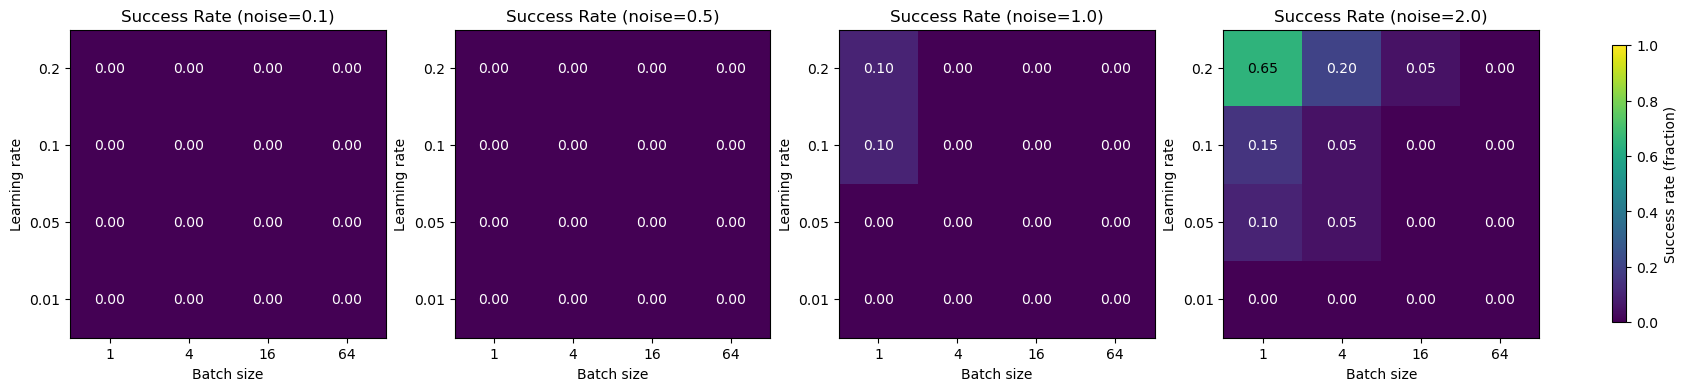

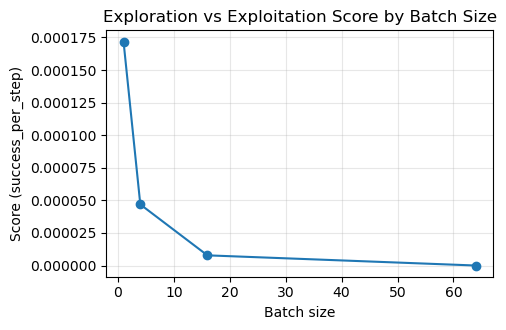

[Q1] Best batch size by 'success_per_step' (aggregated over ('learning_rate', 'noise_scale')): 1


In [22]:
results = sgd_parameter_study()
q1 = analysis_q1_best_batch_size(results, aggregate_over=("learning_rate","noise_scale"), metric="success_per_step")

### Q1 - Batch size: exploration vs. exploitation

**Metric used.** I scored each batch size by $\text{score}=\dfrac{\text{success\_rate}}{\text{median\_steps}+10^{-9}}$, averaged over learning rates and noise scales.

**Result.** The best trade-off is at **batch size $b=1$** (highest score in the plot), with the score dropping sharply as $b$ increases (4 → 16 → 64).

**Interpretation.** Small batches inject more gradient noise, which boosts **exploration** and helps escape local minima. Larger batches reduce stochasticity (good for **exploitation**/fine-tuning) but get stuck more often on this rugged landscape; hence their lower score.

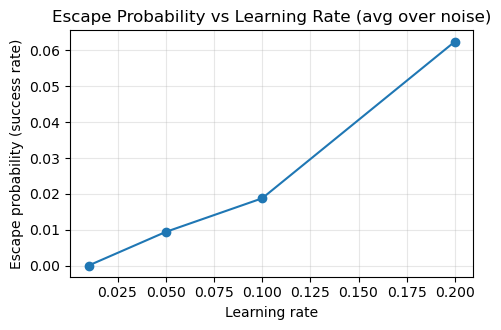

[Q2] Best learning rate by escape probability (avg over noise): 0.2 (escape=0.06)


In [23]:
q2 = analysis_q2_escape_probability(results, noise_scale=None, average_over_batch=True)

### Q2 — Escape probability vs. learning rate

**Observation.** Escape probability rises monotonically with the learning rate:  
- At $\eta=0.01$, escape probability is essentially 0.  
- At $\eta=0.05$ and $0.10$, it increases slightly (~0.01–0.02).  
- At $\eta=0.20$, escape probability reaches ~0.06 (the maximum).  

**Interpretation.** Larger step sizes make it easier to **escape shallow local minima**, since updates can “jump” out of basins. However, too large a learning rate risks overshooting or instability. In this experiment, $\eta=0.20$ gave the best balance, but the curve suggests diminishing returns and potential instability if increased further.

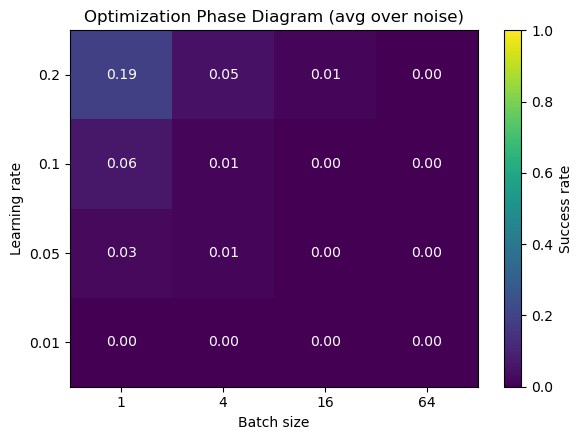

In [24]:
q3 = analysis_q3_phase_diagram(results, noise_scale=None, threshold=0.6, annotate=True)

### Q3 — Optimization phase diagram

**Observation.**  
- Success is concentrated in the **top-left corner** of the diagram: small batch size ($1$) and high learning rate ($0.2$) gave the highest success rate (~0.19).  
- As batch size increases (≥16), success collapses to nearly 0 across all learning rates.  
- Lower learning rates (≤0.05) also show negligible success, regardless of batch size.

**Interpretation.**  
- The best-performing regime is **high learning rate + very small batch size**, where injected noise plus larger steps enable exploration and escaping local minima.  
- Larger batch sizes reduce stochasticity, making SGD behave like GD and thus get stuck in local wells.  
- The diagram highlights a narrow band of “successful” hyperparameters; outside this band, the algorithm consistently fails to reach the global minimum.

# Problem 4 (10 pts): The Perceptron Problem - Understanding Linear Separability Limitations

## What is a Perceptron?

Based on our lecture, a **perceptron** is a binary classifier that makes predictions using a linear decision boundary. It consists of:

- **Inputs**: A feature vector $x \in \mathbb{R}^d$
- **Weights**: A weight vector $w \in \mathbb{R}^d$
- **Bias**: A scalar bias term $b \in \mathbb{R}$
- **Activation**: A step function (threshold function)

The perceptron computes:
$$ f(x) = \text{step} (w^T x + b) $$

Where the step function outputs:
$$ \text{step}(w^T x + b) = \begin{cases}
1 & \text{if} \quad w^T x + b \geq 0 \\
0 & \text{if} \quad w^T x + b < 0
\end{cases} $$

The decision boundary is the hyperplane defined by $w^T x + b = 0$, which divides the input space into two regions.

## The Fundamental Problem

The perceptron suffers from a **critical limitation**: it can only solve **linearly separable** problems. This means it can only correctly classify data where the two classes can be perfectly separated by a single straight line (in 2D) or hyperplane (in higher dimensions).

### The XOR Problem: A Classic Example

The most famous demonstration of this limitation is the **XOR (Exclusive OR) problem**:

| x₁ | x₂ | XOR Output |
|----|----|------------|
| 0  | 0  | 0          |
| 0  | 1  | 1          |
| 1  | 0  | 1          |
| 1  | 1  | 0          |

If you plot these four points:
- Points (0,1) and (1,0) should be classified as class 1 (XOR = 1)
- Points (0,0) and (1,1) should be classified as class 0 (XOR = 0)

**No single straight line can separate these classes!** The pattern requires a non-linear decision boundary.

## Why This Matters

This limitation reveals why:

1. **Single perceptrons are insufficient** for many real-world problems
2. **We need non-linearity** in our models (like ReLU activation functions)
3. **Multiple layers are essential** to create complex, non-linear decision boundaries
4. **The XOR problem motivated** the development of multi-layer neural networks

As we learned in our previous lecture, when we combine multiple ReLU neurons and stack them in layers, we can create complex, bent decision boundaries that can solve non-linearly separable problems like XOR.

This historical limitation of the perceptron was so significant that it contributed to the "AI winter" of the 1970s, until researchers developed multi-layer networks with backpropagation in the 1980s.


To Do: Fill in the blanks marked by **TODO**.

Learning Objectives

1. Implement a perceptron from scratch to understand its mechanics
2. Demonstrate why linear models fail on non-linearly separable data
3. Visualize decision boundaries and their limitations
4. Show how adding non-linear features can solve the problem

XOR Dataset - The Classic Non-Linearly Separable Problem:
Inputs (X):
[[0 0]
 [0 1]
 [1 0]
 [1 1]]
Outputs (y):
[0 1 1 0]

Notice: Points (0,1) and (1,0) have output 1, while (0,0) and (1,1) have output 0
No single straight line can separate these two classes!


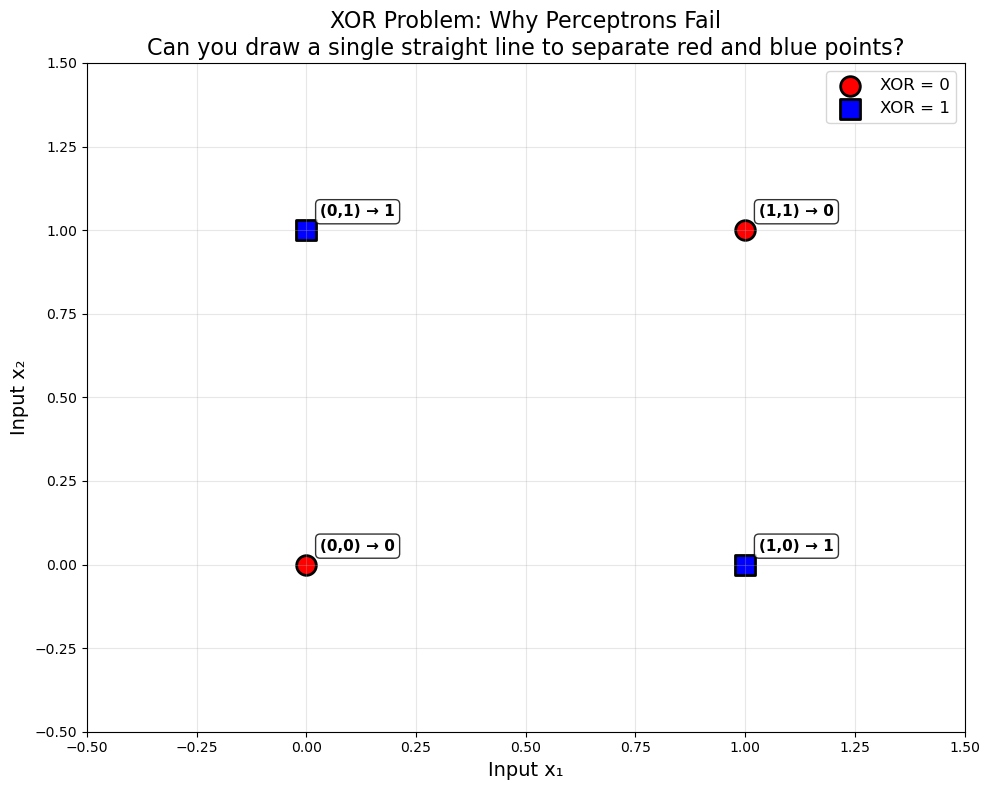

In [28]:
import numpy as np
import matplotlib.pyplot as plt

## Part 1: Creating the XOR Dataset

def create_xor_dataset():
    """
    Create the classic XOR dataset that demonstrates linear non-separability.
    This is the problem that historically showed perceptron limitations.
    """
    X = np.array([[0, 0],
                  [0, 1],
                  [1, 0],
                  [1, 1]])
    y = np.array([0, 1, 1, 0])

    return X, y

# Create the XOR dataset
X_xor, y_xor = create_xor_dataset()
print("XOR Dataset - The Classic Non-Linearly Separable Problem:")
print("Inputs (X):")
print(X_xor)
print("Outputs (y):")
print(y_xor)
print("\nNotice: Points (0,1) and (1,0) have output 1, while (0,0) and (1,1) have output 0")
print("No single straight line can separate these two classes!")


## Part 2: Visualizing the Non-Linear Separability Problem

def plot_xor_data(X, y):
    """
    Visualize the XOR problem to show why it's non-linearly separable.
    This plot clearly shows the geometric impossibility for a perceptron.
    """
    plt.figure(figsize=(10, 8))
    class_0_mask = (y == 0)
    class_1_mask = (y == 1)
    plt.scatter(X[class_0_mask, 0], X[class_0_mask, 1], c='red', marker='o', s=200, label='XOR = 0', edgecolor='black', linewidth=2)
    plt.scatter(X[class_1_mask, 0], X[class_1_mask, 1], c='blue', marker='s', s=200, label='XOR = 1', edgecolor='black', linewidth=2)

    plt.xlabel('Input x₁', fontsize=14)
    plt.ylabel('Input x₂', fontsize=14)
    plt.title('XOR Problem: Why Perceptrons Fail\nCan you draw a single straight line to separate red and blue points?', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xlim(-0.5, 1.5)
    plt.ylim(-0.5, 1.5)

    # Add text annotations for each point showing the XOR computation
    for i in range(len(X)):
        plt.annotate(f'({X[i,0]},{X[i,1]}) → {y[i]}',
                    (X[i,0], X[i,1]),
                    xytext=(10, 10), textcoords='offset points',
                    fontsize=11, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.tight_layout()
    plt.show()

plot_xor_data(X_xor, y_xor)

In [29]:
class SimplePerceptron:
    """
    A simple perceptron implementation to demonstrate the linear threshold mechanism.
    This follows the classic perceptron learning algorithm from our lectures.
    """
    def __init__(self, learning_rate=0.1, max_epochs=1000):
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.weights = None
        self.bias = None
        self.training_errors = []

    def _activation_function(self, z):
        """Step function: returns 1 if z >= 0, else 0"""
        return np.where(z >= 0, 1, 0)

    def fit(self, X, y):
        """
        Train the perceptron using the classic perceptron learning rule:
        w = w + η(target - prediction) * input
        """
        n_samples, n_features = X.shape

        # Initialize weights randomly (small values) and bias to zero
        self.weights = np.random.randn(n_features) * 0.01
        self.bias = 0.0

        # Training loop - implement the perceptron learning algorithm
        for epoch in range(self.max_epochs):
            # Number of wrong predictions in current epoch
            errors = 0

            for i in range(n_samples):
                # Compute the linear combination (net input)
                linear_output = np.dot(X[i], self.weights) + self.bias

                # Apply step function to get prediction
                prediction = self._activation_function(linear_output)

                # Calculate the error (target - prediction)
                error = y[i] - prediction

                # Only update weights if there's an error (classic perceptron rule)
                if error != 0:
                    errors += 1

                    # Apply perceptron update rule
                    self.weights += self.learning_rate * error * X[i]
                    self.bias += self.learning_rate * error

            self.training_errors.append(errors)

            # If no errors in this epoch, we've converged (for linearly separable data)
            if errors == 0:
                print(f"Converged after {epoch + 1} epochs!")
                break
        else:
            print(f"Did not converge after {self.max_epochs} epochs - likely not linearly separable!")

    def predict(self, X):
        """Make predictions using the learned decision boundary"""
        linear_output = np.dot(X, self.weights) + self.bias
        return self._activation_function(linear_output)

    def get_decision_boundary_params(self):
        """
        Get parameters for plotting the decision boundary line.
        Decision boundary: w₁x₁ + w₂x₂ + b = 0
        Rearranged as: x₂ = -(w₁x₁ + b) / w₂
        """
        if len(self.weights) == 2 and self.weights[1] != 0:
            slope = -self.weights[0] / self.weights[1]
            intercept = -self.bias / self.weights[1]
            return slope, intercept
        return None, None

In [30]:
from sklearn.metrics import accuracy_score

## Part 4: Training the Perceptron on XOR and Observing the Failure

print("Training a perceptron on the XOR problem...")
print("Expected result: The perceptron will fail to learn the correct pattern!")
print("-" * 60)

# Create and train the perceptron
perceptron = SimplePerceptron(learning_rate=0.1, max_epochs=1000)
perceptron.fit(X_xor, y_xor)

# Make predictions and evaluate
predictions = perceptron.predict(X_xor)
accuracy = accuracy_score(y_xor, predictions)

print(f"\nFinal Results:")
print(f"Accuracy: {accuracy:.2f} (Perfect would be 1.00)")
print(f"Final weights: {perceptron.weights}")
print(f"Final bias: {perceptron.bias:.3f}")

print("\nPredictions vs True values:")
print("Input  | True | Predicted | Correct?")
print("-" * 36)
for i in range(len(X_xor)):
    correct = "✓" if predictions[i] == y_xor[i] else "✗"
    print(f"{X_xor[i]}  |  {y_xor[i]}   |     {predictions[i]}     |    {correct}")

Training a perceptron on the XOR problem...
Expected result: The perceptron will fail to learn the correct pattern!
------------------------------------------------------------
Did not converge after 1000 epochs - likely not linearly separable!

Final Results:
Accuracy: 0.50 (Perfect would be 1.00)
Final weights: [-0.01344285  0.00191693]
Final bias: 0.000

Predictions vs True values:
Input  | True | Predicted | Correct?
------------------------------------
[0 0]  |  0   |     1     |    ✗
[0 1]  |  1   |     1     |    ✓
[1 0]  |  1   |     0     |    ✗
[1 1]  |  0   |     0     |    ✓


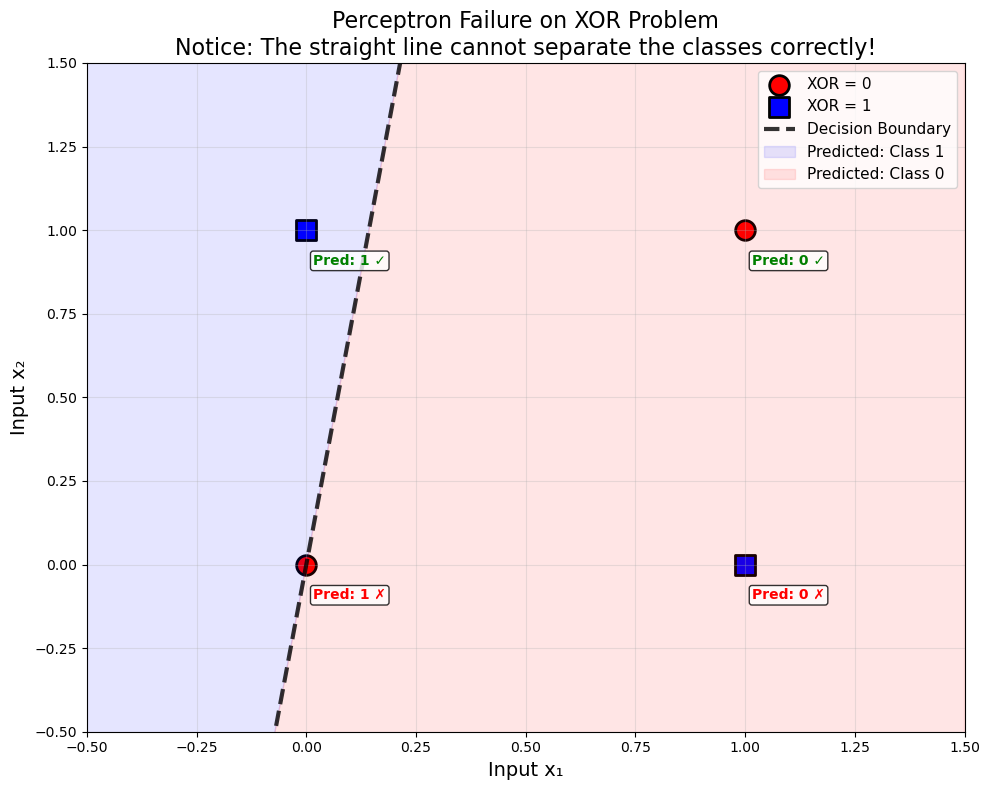

In [31]:
## Part 5: Visualizing the Decision Boundary and the Failure

def plot_perceptron_decision_boundary(X, y, perceptron, title="Perceptron Decision Boundary"):
    """
    Plot the data points and the linear decision boundary learned by the perceptron.
    This visualization clearly shows why the linear boundary fails on XOR.
    """
    plt.figure(figsize=(10, 8))

    # Plot the data points
    class_0_mask = (y == 0)
    class_1_mask = (y == 1)
    plt.scatter(X[class_0_mask, 0], X[class_0_mask, 1], c='red', marker='o', s=200,
                label='XOR = 0', edgecolor='black', linewidth=2)
    plt.scatter(X[class_1_mask, 0], X[class_1_mask, 1], c='blue', marker='s', s=200,
                label='XOR = 1', edgecolor='black', linewidth=2)

    # Plot the decision boundary
    slope, intercept = perceptron.get_decision_boundary_params()

    if slope is not None:
        x_line = np.linspace(-0.5, 1.5, 100)
        y_line = slope * x_line + intercept
        plt.plot(x_line, y_line, 'k--', linewidth=3, label='Decision Boundary', alpha=0.8)

        # Show which side is which (according to the linear rule)
        plt.fill_between(x_line, y_line, 2, alpha=0.1, color='blue', label='Predicted: Class 1')
        plt.fill_between(x_line, y_line, -1, alpha=0.1, color='red', label='Predicted: Class 0')
    else:
        plt.text(0.5, 1.3, "Decision boundary undefined (w₂ ≈ 0)", ha='center', fontsize=12,
                 bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.8))

    # Show predictions as text annotations
    predictions = perceptron.predict(X)
    for i in range(len(X)):
        color = 'green' if predictions[i] == y[i] else 'red'
        marker = '✓' if predictions[i] == y[i] else '✗'
        plt.annotate(f'Pred: {predictions[i]} {marker}',
                     (X[i, 0], X[i, 1]),
                     xytext=(5, -25), textcoords='offset points',
                     color=color, fontweight='bold', fontsize=10,
                     bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))

    plt.xlabel('Input x₁', fontsize=14)
    plt.ylabel('Input x₂', fontsize=14)
    plt.title(title + '\nNotice: The straight line cannot separate the classes correctly!', fontsize=16)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.xlim(-0.5, 1.5)
    plt.ylim(-0.5, 1.5)
    plt.tight_layout()
    plt.show()

plot_perceptron_decision_boundary(X_xor, y_xor, perceptron,
                                  "Perceptron Failure on XOR Problem")

In [32]:
## Part 6: The Solution — Non-Linear Feature Engineering

def create_nonlinear_features(X):
    """
    Transform the XOR problem into a (now) linearly separable one by adding a non-linear feature.
    We'll add the interaction term x1*x2:
        X_enhanced = [x1, x2, x1*x2]
    """
    x1x2 = (X[:, 0] * X[:, 1])[:, None]   # shape (n, 1)
    X_enhanced = np.hstack([X, x1x2])     # shape (n, 3)
    return X_enhanced

# Create enhanced features
X_enhanced = create_nonlinear_features(X_xor)

print("Original XOR problem:")
print("Inputs (x1, x2):")
print(X_xor)
print("\nEnhanced with non-linear features:")
print("Inputs (x1, x2, x1*x2):")
print(X_enhanced)
print("\nOutputs:", y_xor)

print("\nKey insight: In the enhanced space, the problem becomes linearly separable!")
for i in range(len(X_enhanced)):
    print(f"Point {X_enhanced[i]} → class {y_xor[i]}")

# (Optional) Train perceptron on the enhanced features to verify perfect separation
perceptron_nl = SimplePerceptron(learning_rate=0.1, max_epochs=1000)
perceptron_nl.fit(X_enhanced, y_xor)
pred_nl = perceptron_nl.predict(X_enhanced)
acc_nl = accuracy_score(y_xor, pred_nl)
print(f"\nPerceptron with non-linear features accuracy: {acc_nl:.2f} (should be 1.00)")
print(f"Weights: {perceptron_nl.weights},  Bias: {perceptron_nl.bias:.3f}")


Original XOR problem:
Inputs (x1, x2):
[[0 0]
 [0 1]
 [1 0]
 [1 1]]

Enhanced with non-linear features:
Inputs (x1, x2, x1*x2):
[[0 0 0]
 [0 1 0]
 [1 0 0]
 [1 1 1]]

Outputs: [0 1 1 0]

Key insight: In the enhanced space, the problem becomes linearly separable!
Point [0 0 0] → class 0
Point [0 1 0] → class 1
Point [1 0 0] → class 1
Point [1 1 1] → class 0
Converged after 10 epochs!

Perceptron with non-linear features accuracy: 1.00 (should be 1.00)
Weights: [ 0.10024465  0.19759113 -0.29887648],  Bias: -0.100


In [33]:
from sklearn.linear_model import Perceptron

# Train a perceptron on the enhanced features
print("\nTraining perceptron on enhanced features...")
enhanced_perceptron = Perceptron(random_state=42, max_iter=1000)
enhanced_perceptron.fit(X_enhanced, y_xor)

enhanced_predictions = enhanced_perceptron.predict(X_enhanced)
enhanced_accuracy = accuracy_score(y_xor, enhanced_predictions)

print(f"\nResults with non-linear features:")
print(f"Accuracy: {enhanced_accuracy:.2f} (Perfect!)")
print(f"Weights: {enhanced_perceptron.coef_[0]}")
print(f"Bias: {enhanced_perceptron.intercept_[0]:.3f}")

print("\nPredictions vs True values:")
print("Enhanced Input | True | Predicted | Correct?")
print("-" * 44)
for i in range(len(X_enhanced)):
    correct = "✓" if enhanced_predictions[i] == y_xor[i] else "✗"
    print(f"{X_enhanced[i]}        |  {y_xor[i]}   |     {enhanced_predictions[i]}     |    {correct}")

print(f"\nConclusion: By adding non-linear features, we made XOR linearly separable!")
print("This is exactly what hidden layers in neural networks do automatically!")


Training perceptron on enhanced features...

Results with non-linear features:
Accuracy: 1.00 (Perfect!)
Weights: [ 2.  2. -5.]
Bias: -1.000

Predictions vs True values:
Enhanced Input | True | Predicted | Correct?
--------------------------------------------
[0 0 0]        |  0   |     0     |    ✓
[0 1 0]        |  1   |     1     |    ✓
[1 0 0]        |  1   |     1     |    ✓
[1 1 1]        |  0   |     0     |    ✓

Conclusion: By adding non-linear features, we made XOR linearly separable!
This is exactly what hidden layers in neural networks do automatically!
